## Exploring the Correlation Between Global Gross Domestic Product (GDP) and the Consumer Price Index (CPI)

<style>
.custom-heading {
    margin-bottom: 10px; /* spacing between title and content */
    font-size: 20px; /* title font size */
}
.custom-spacing li{
    margin-top: 10px; /* spacing between list elements */
    font-size: 17.5px; /* content font size */
}
</style>


### **Introduction**
This Jupyter Notebook investigates the relationship between Gross Domestic Product (GDP) and the Consumer Price Index (CPI) across Asia, Europe, and North America. The study is motivated by the [Phillips Curve](https://en.wikipedia.org/wiki/Phillips_curve) theory, which suggests an inverse relationship between inflation rates and Gross Domestic Product.

Our objective is to explore whether this theory holds when comparing unemployment rates with CPI, a key measure of inflation. We aim to analyze historical data to discern how these two critical economic indicators interact, focusing on their correlation and possible implications. The analysis encompasses data collection, cleaning, and visualization, followed by statistical modeling to comprehensively understand their interconnected dynamics.

---

<h3 class="custom-heading"><b>Contributor(s)</b></h3>
<ul class="custom-spacing">
  <li>Code Originator(s): Hexuan Fan</li>
  <li>Code Reviewer(s): Hexuan Fan, Xiaohan Kuang, Ananya Nimbalkar, Ziji Tang</li>
  <li>Code Reviser(s): Xiaohan Kuang</li>
</ul>

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  <li>This code chunk is responsible for importing all the necessary Python libraries required for data processing and visualization in our analysis of the relationship between GDP and CPI. To ensure a clean output, we also suppress warnings.</li>
  <li>The <code>LOCAL_PATH</code> variable is set to point to the data folder in the current working directory. </li> 
  <li>The <code>CLEANED_PATH</code> variable is set to point to the cleaned data folder in the current working directory. </li>
  <li>The <code>RAW_PATH</code> variable is set to point to the raw data folder in the current working directory. </li>
  <li>The <code>PLOT_PATH</code> variable is set to point to the plots folder in the current working directory. </li>
</ul>

In [1]:
import os
import pandas as pd
import pycountry
import pycountry_convert as pc
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from pycountry_convert import country_alpha3_to_country_alpha2, country_alpha2_to_continent_code
import warnings
warnings.filterwarnings("ignore")

LOCAL_PATH = os.getcwd() + '/data/'
CLEANED_PATH = LOCAL_PATH + '/cleaned/'
RAW_PATH = LOCAL_PATH + '/raw/'
PLOT_PATH = os.getcwd() + '/plots/'

In [2]:
current_directory = os.getcwd()
print(f"Current working directory: {current_directory}")

Current working directory: c:\Users\alan_\Desktop\DS-5610-Exploratory_Data_Analysis\final_project\final-project-group_10


In [3]:
xls_path1 = CLEANED_PATH + 'CPI_cleaned.xlsx'
xls_path2 = RAW_PATH + 'API_NY.GDP.MKTP.CD_DS2_en_excel_v2_5994847.xls'

In [4]:
df_cpi = pd.read_excel(xls_path1)
df1 = pd.read_excel(xls_path2, 'Data', skiprows = 3)
df2 = pd.read_excel(xls_path2, 'Metadata - Countries')

In [5]:
def pre_cleaning(df1, df2):
    # Merging the two dataframes based on 'Country Code' ensuring the information matches correctly
    merged_df = pd.merge(df1, df2[['Country Code', 'IncomeGroup', 'Region']], on='Country Code', how='left')

    # Drop column from 1960 to 1999
    cols_to_drop = [str(year) for year in range(1960, 2000)]
    merged_df = merged_df.drop(columns=cols_to_drop, errors='ignore')

    # Reordering the columns to place 'IncomeGroup' and 'Region' after 'Country Code'
    cols = merged_df.columns.tolist()
    incomegroup_index = cols.index('IncomeGroup')
    region_index = cols.index('Region')
    new_order = cols[:3] + [cols[incomegroup_index]] + [cols[region_index]] + cols[3:incomegroup_index] + cols[incomegroup_index+1:region_index] + cols[region_index+1:]
    merged_df = merged_df[new_order]

    # Reorder data based on 'Region'
    merged_df = merged_df.sort_values(by='Region', na_position='last')

    return merged_df

# 'Continent' mapping function
def get_continent_name_from_alpha3(alpha_3_code):
    try:
        alpha_2_code = pc.country_alpha3_to_country_alpha2(alpha_3_code)
        continent_code = pc.country_alpha2_to_continent_code(alpha_2_code)
        continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        return continent_name
    except:
        return None

# Use a few lines of hard code to fill in map which Country Code cannot be identified
continent_mapping = {
    "Timor-Leste": "Asia",
    "Kosovo": "Europe",
    "Channel Islands": "Europe",
    "Sint Maarten (Dutch part)": "North America",
}

def map_continent(row):
    name = row['Country Name']
    return continent_mapping.get(name, None)

In [6]:
# Apply
df_gdp = pre_cleaning(df1, df2)
df_gdp['Continent'] = df_gdp['Country Code'].apply(get_continent_name_from_alpha3)
country_code_col_index = df_gdp.columns.get_loc('Country Code')
df_gdp.insert(country_code_col_index + 1, 'Continent', df_gdp.pop('Continent'))
df_gdp['Continent'] = df_gdp.apply(lambda row: map_continent(row) if pd.isna(row['Continent']) else row['Continent'], axis = 1)

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  This code chunk loads a world map from geopandas and merges it with the 2022 GDP. The map includes a color bar for interpreting these values, categorizing GDP from 1×10^6 to 1×10^13. While dark green represents a high level of GDP, lighter green indicates a relatively lower GDP. Also, the plot contains countries that are in North America, Europe, and Asia.
</ul>

---

<h3 class="custom-heading"><b>Contributor(s)</b></h3>
<ul class="custom-spacing">
  <li>Code Reviser(s): Xiaohan Kuang</li>
</ul>

---

<h3 class="custom-heading"><b>Edit Information</b></h3>
<ul class="custom-spacing">
  <li> Adjusted the map legend and size for a consistent and uniform appearance.
</ul>

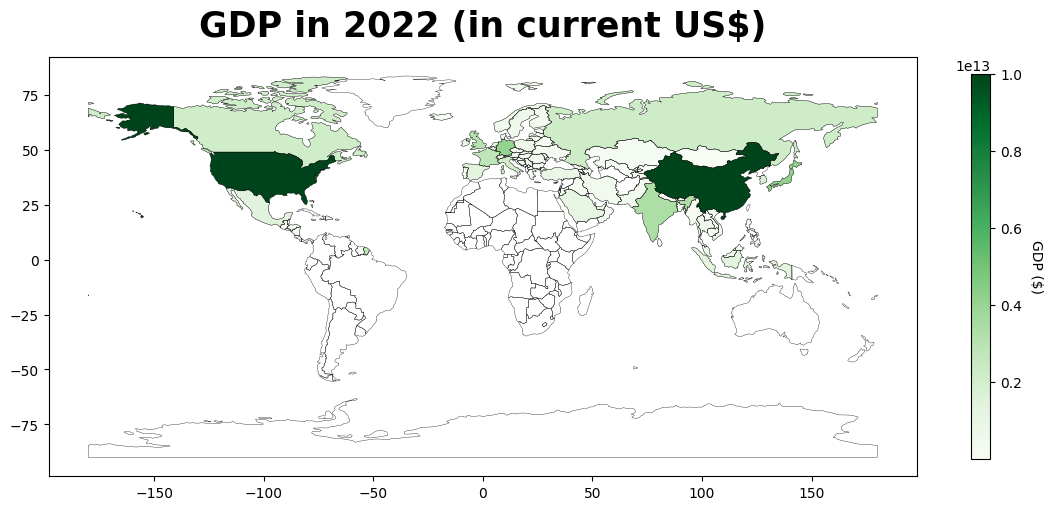

In [7]:
gdp_map_data = df_gdp[['Country Name', 'Country Code', 'Continent', '2022']]
interested_continents = ['Asia', 'Europe', 'North America']
filtered_gdp_map_data = gdp_map_data[gdp_map_data['Continent'].isin(interested_continents)]

# Load world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the world map with the GDP data
world_gdp = world.merge(filtered_gdp_map_data, left_on = 'iso_a3', right_on = 'Country Code', how='left')

# Plotting
fig, ax = plt.subplots(figsize = (14, 10))

plt.title('GDP in 2022 (in current US$)', fontweight = "bold", pad=15, fontsize = 25)

world_gdp.boundary.plot(ax=ax, linewidth=0.25, color='black')

# Plotting the world as the base layer
# world.plot(ax = ax, color = 'white', edgecolor = 'black', linewidth=0.1)

# Overlaying countries from AS, NA, and EU
world_gdp.plot(column = '2022', 
               ax = ax, 
               edgecolor = 'black', 
               cmap = 'Greens', 
               vmin=1e6, 
               vmax=1e13,  
               linewidth=0.1)

sm = plt.cm.ScalarMappable(cmap='Greens', norm=plt.Normalize(vmin=1e6, vmax=10e12))
sm._A = [] 

cbar = fig.colorbar(sm, ax=ax, shrink=0.5)
cbar.set_label('GDP ($)',  rotation=270, labelpad=15)
plt.savefig(PLOT_PATH + "GDP_2022.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  These code trunks below aim to minimize the bias generated from missing values in the original data. It generated the .csv cleaned GDP dataset, identified and dropped countries that have no available data from the year 2000 to 2022 in both CPI and GDP DataFrames. Then, linear interpolation has been applied to both DataFrames.
</ul>


In [8]:
xlsx_path_new = str(current_directory) + './data/cleaned/GDP_cleaned.xlsx'
df_gdp.to_excel(xlsx_path_new)

In [9]:
# Find countries in df_cpi where columns from 2000 to 2022 are all NaN
all_nan_cpi = df_cpi[df_cpi.loc[:, '2000':'2022'].isna().all(axis = 1)]['Country Name']
all_nan_cpi.tolist()

['French Polynesia',
 'Northern Mariana Islands',
 'Guam',
 'Marshall Islands',
 'American Samoa',
 "Korea, Dem. People's Rep.",
 'Faroe Islands',
 'Isle of Man',
 'Liechtenstein',
 'Greenland',
 'Gibraltar',
 'Andorra',
 'Channel Islands',
 'Monaco',
 'Turkmenistan',
 'Puerto Rico',
 'St. Martin (French part)',
 'British Virgin Islands',
 'Virgin Islands (U.S.)',
 'Argentina',
 'Cuba',
 'Turks and Caicos Islands',
 'Bermuda',
 'Eritrea',
 'Somalia',
 'Not classified']

In [10]:
# Remove from both df_cpi and df_gdp
df_cpi = df_cpi[~df_cpi['Country Name'].isin(all_nan_cpi)]
df_gdp = df_gdp[~df_gdp['Country Name'].isin(all_nan_cpi)]

In [11]:
# Linear interpolation
years = [str(year) for year in range(2000, 2023)]
df_cpi_int = df_cpi.copy()
df_gdp_int = df_gdp.copy()
df_cpi_int[years] = df_cpi_int[years].interpolate(method = 'linear', axis = 1)
df_gdp_int[years] = df_gdp_int[years].interpolate(method = 'linear', axis = 1)

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for data analysis and visualization, specifically for plotting the median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) growth rate for Asian countries from 2000 to 2022. 
  <li>The code calculates the median CPI and median GDP growth rate for Asian countries, using a dataset that categorizes data by continent. 
  <li>It performs a percentage change calculation on the GDP data to represent the growth rate and takes the median across Asian countries for each year.
  <li>A line plot is created, with years on the x-axis and percentages on the y-axis, showing trends in median CPI and GDP growth, with markers for each year.
  <li>Vertical dashed lines and labels are added to highlight the years of the Global Financial Crisis (2008) and the Covid-19 Pandemic (2020).
</ul>

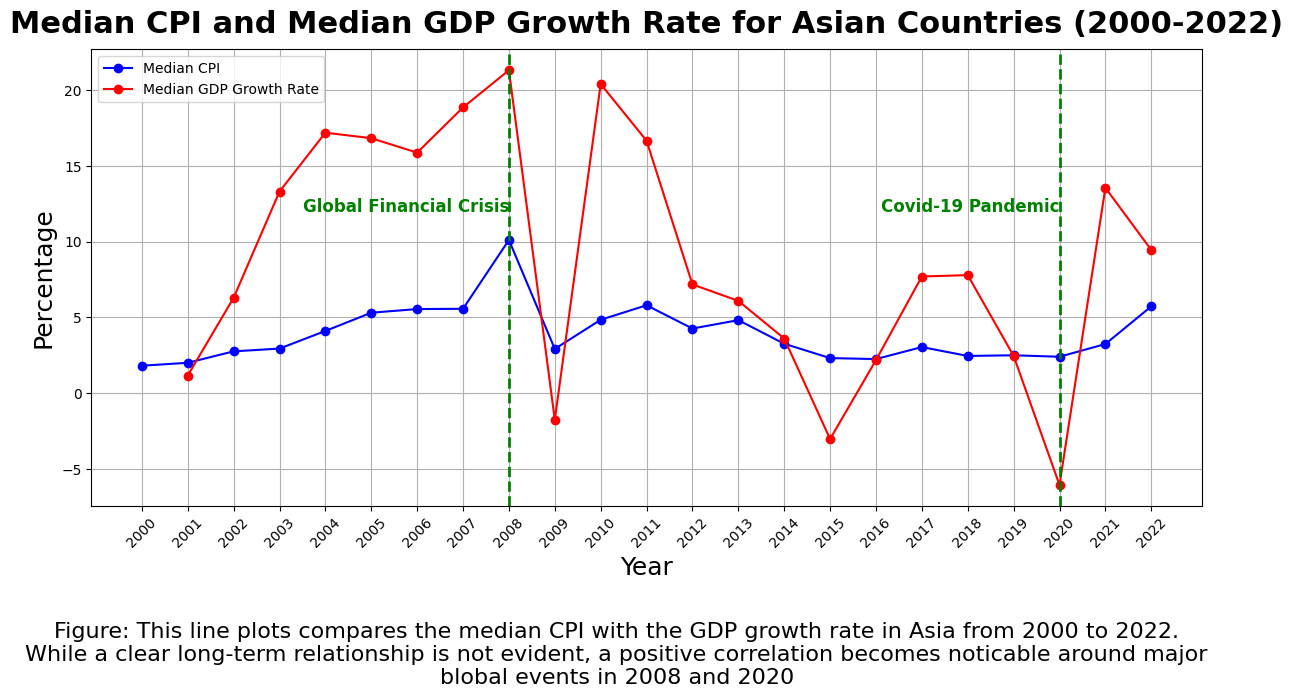

In [12]:
# Asia
df_cpi_asia = df_cpi_int[df_cpi_int['Continent'] == 'Asia']
df_gdp_asia = df_gdp_int[df_gdp_int['Continent'] == 'Asia']

# Calculating GDP growth rate for Asian countries
median_cpi_asia = df_cpi_asia[years].median()
gdp_growth_asia = df_gdp_asia[years].pct_change(axis = 1) * 100  # Convert to percentage
median_gdp_growth_asia = gdp_growth_asia.median()

# Plotting
plt.figure(figsize = (12, 6))
plt.plot(years, median_cpi_asia, label = 'Median CPI', marker = 'o', color = 'blue')
plt.plot(years, median_gdp_growth_asia, label = 'Median GDP Growth Rate', marker = 'o', color = 'red')

# Adding vertical lines for the years 2008 and 2020
plt.axvline(x='2008', color='green', linestyle='--', linewidth=2)
plt.axvline(x='2020', color='green', linestyle='--', linewidth=2)

# Label these global events
plt.text('2008', 12, 'Global Financial Crisis', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")
plt.text('2020', 12, 'Covid-19 Pandemic', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")

plt.title('Median CPI and Median GDP Growth Rate for Asian Countries (2000-2022)',  fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
caption = """Figure: This line plots compares the median CPI with the GDP growth rate in Asia from 2000 to 2022.
While a clear long-term relationship is not evident, a positive correlation becomes noticable around major blobal events in 2008 and 2020"""
plt.figtext(0.5, -0.1, caption, ha='center', va='center', fontsize=16, wrap=True)
plt.tight_layout()
plt.savefig(PLOT_PATH + "median_cpi_and_gdp_growth_rate_in_Asia.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The below is creating a scatter plot visualizing the relationship between median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) for Asian countries, using data from the years 2000 to 2022.
  <li>Merges two datasets containing CPI and GDP data for Asian countries, adding appropriate suffixes to distinguish the two.
  <li>Calculates the median CPI and median GDP for each country over the specified years.
  <li>Generates a scatter plot with median CPI on the x-axis and median GDP on the y-axis, applying a logarithmic scale to the GDP axis if there is a large range of values.
  <li>Annotates each data point with the corresponding country name for identification.
</ul>


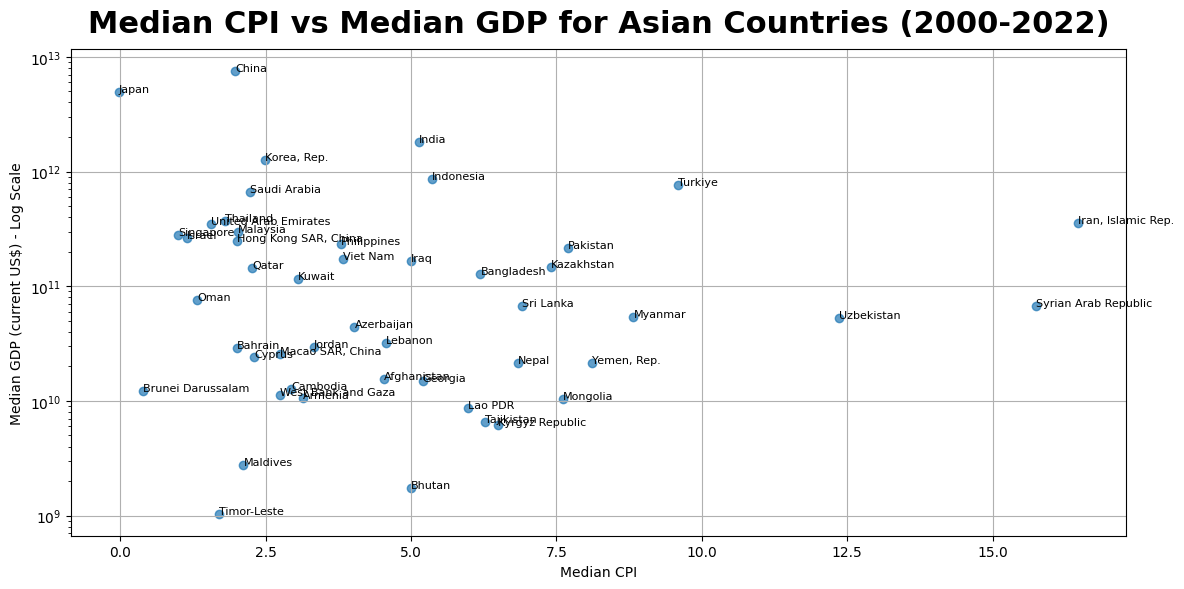

In [13]:
df_merged = pd.merge(df_cpi_asia, df_gdp_asia, on="Country Name", suffixes=('_cpi', '_gdp'))

# Correcting the error in concatenating the years with suffixes for CPI and GDP
cpi_columns = [year + '_cpi' for year in years]
gdp_columns = [year + '_gdp' for year in years]

# Calculate median CPI and GDP for each country across 2000-2022
df_merged['median_cpi'] = df_merged[cpi_columns].median(axis=1)
df_merged['median_gdp'] = df_merged[gdp_columns].median(axis=1)

# Scatter plot
plt.figure(figsize=(12, 6))
plt.scatter(df_merged['median_cpi'], df_merged['median_gdp'], alpha=0.7)

# Labeling
plt.title('Median CPI vs Median GDP for Asian Countries (2000-2022)', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Median CPI')
plt.ylabel('Median GDP (current US$)')
plt.grid(True)

# Log scale for GDP if needed due to wide range of values
if df_merged['median_gdp'].max() / df_merged['median_gdp'].min() > 1000:
    plt.yscale('log')
    plt.ylabel('Median GDP (current US$) - Log Scale')

# Annotation of country names
for i, row in df_merged.iterrows():
    plt.annotate(row['Country Name'], (row['median_cpi'], row['median_gdp']), fontsize=8)
plt.tight_layout()
plt.savefig(PLOT_PATH + "median_cpi_and_gdp_scatterplot_in_Asia.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for processing economic data and creating a scatter plot to visualize the relationship between the Consumer Price Index (CPI) and GDP growth rate for Asian countries.
  <li>Reshapes the CPI and GDP data from wide to long format, preparing it for merging by country name and year. Calculates the GDP growth rate as a percentage change from the previous year for each country.
  <li>Merges the reshaped CPI data with the calculated GDP growth rates based on country and year. Removes any rows with missing values to clean the data for plotting.
  <li>Plots a scatter plot using Seaborn, mapping CPI to the x-axis and GDP growth rate to the y-axis, with different colors representing different countries. The plot does not include a legend to avoid cluttering.
  <li>Adds a regression line to the scatter plot to indicate trends, although the caption suggests that no clear pattern is discernible.
</ul>


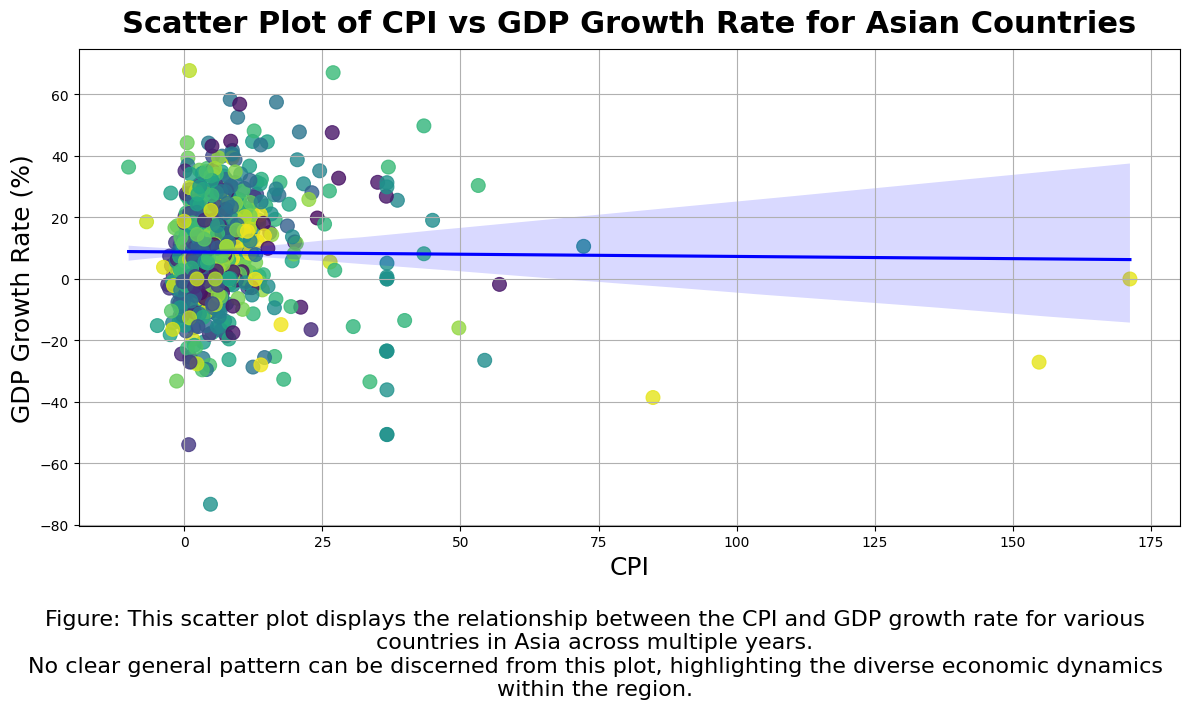

In [14]:
cpi_reshaped_countries = df_cpi_asia.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='CPI')

# Correcting the approach for merging and plotting
# Ensuring correct column names and merging the reshaped CPI and GDP growth data
gdp_growth_reshaped_countries = df_gdp_asia.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='GDP')
gdp_growth_reshaped_countries['GDP Growth Rate'] = gdp_growth_reshaped_countries.groupby('Country Name')['GDP'].pct_change() * 100  # Calculating GDP growth rate in percentage

# Merging the reshaped CPI and GDP growth dataframes for each country
merged_data_countries = pd.merge(cpi_reshaped_countries, gdp_growth_reshaped_countries[['Country Name', 'Year', 'GDP Growth Rate']], on=['Country Name', 'Year'])

# Removing NaN values
merged_data_countries = merged_data_countries.dropna()

# Creating the scatter plot for all countries across all years
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', hue='Country Name', palette='viridis', legend=False, s=100, alpha=0.8, edgecolor=None)
sns.regplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', scatter=False, color='blue')

plt.title('Scatter Plot of CPI vs GDP Growth Rate for Asian Countries', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('CPI', fontsize=18)
plt.ylabel('GDP Growth Rate (%)', fontsize=18)
plt.grid(True)
caption = """Figure: This scatter plot displays the relationship between the CPI and GDP growth rate for various countries in Asia across multiple years.
No clear general pattern can be discerned from this plot, highlighting the diverse economic dynamics within the region."""
plt.figtext(0.5, -0.1, caption, ha='center', va='center', wrap=True, fontsize=16)
plt.tight_layout()
plt.savefig(PLOT_PATH + "cpi_and_gdp_growth_rate_scatterplot_in_Asia.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for data analysis and visualization, specifically for plotting the median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) growth rate for European countries from 2000 to 2022. 
  <li>The code calculates the median CPI and median GDP growth rate for European countries, using a dataset that categorizes data by continent. 
  <li>It performs a percentage change calculation on the GDP data to represent the growth rate and takes the median across European countries for each year.
  <li>A line plot is created, with years on the x-axis and percentages on the y-axis, showing trends in median CPI and GDP growth, with markers for each year.
  <li>Vertical dashed lines and labels are added to highlight the years of the Global Financial Crisis (2008) and the Covid-19 Pandemic (2020).
</ul>

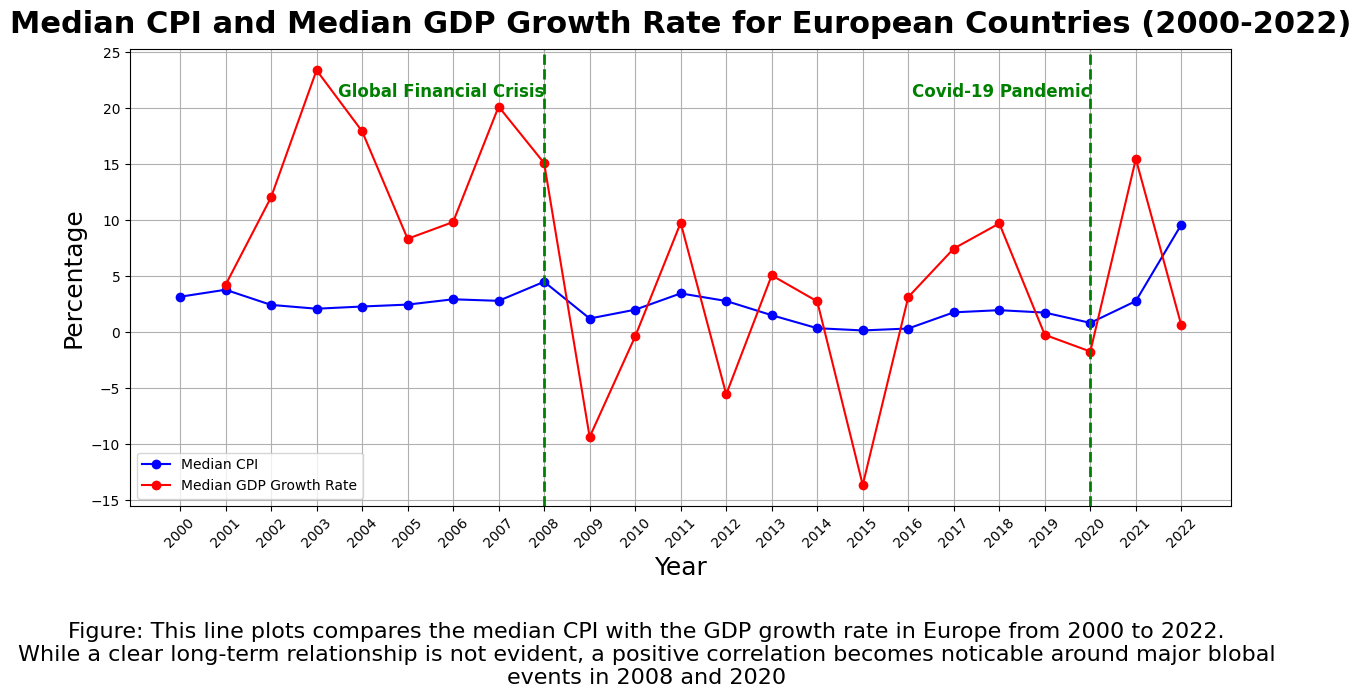

In [15]:
# Europe
df_cpi_euro = df_cpi_int[df_cpi_int['Continent'] == 'Europe']
df_gdp_euro = df_gdp_int[df_gdp_int['Continent'] == 'Europe']

# Calculating GDP growth rate for European countries
median_cpi_euro = df_cpi_euro[years].median()
gdp_growth_euro = df_gdp_euro[years].pct_change(axis = 1) * 100  # Convert to percentage
median_gdp_growth_euro = gdp_growth_euro.median()

# Plotting
plt.figure(figsize = (12, 6))
plt.plot(years, median_cpi_euro, label = 'Median CPI', marker = 'o', color = 'blue')
plt.plot(years, median_gdp_growth_euro, label = 'Median GDP Growth Rate', marker = 'o', color = 'red')

# Adding vertical lines for the years 2008 and 2020
plt.axvline(x='2008', color='green', linestyle='--', linewidth=2)
plt.axvline(x='2020', color='green', linestyle='--', linewidth=2)

# Label these global events
plt.text('2008', 21, 'Global Financial Crisis', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")
plt.text('2020', 21, 'Covid-19 Pandemic', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")

plt.title('Median CPI and Median GDP Growth Rate for European Countries (2000-2022)', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
caption = """Figure: This line plots compares the median CPI with the GDP growth rate in Europe from 2000 to 2022.
While a clear long-term relationship is not evident, a positive correlation becomes noticable around major blobal events in 2008 and 2020"""
plt.figtext(0.5, -0.1, caption, ha='center', va='center', fontsize=16, wrap=True)
plt.tight_layout()
plt.savefig(PLOT_PATH + "median_cpi_and_gdp_growth_rate_in_Europe.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The below is creating a scatter plot visualizing the relationship between median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) for European countries, using data from the years 2000 to 2022.
  <li>Merges two datasets containing CPI and GDP data for European countries, adding appropriate suffixes to distinguish the two.
  <li>Calculates the median CPI and median GDP for each country over the specified years.
  <li>Generates a scatter plot with median CPI on the x-axis and median GDP on the y-axis, applying a logarithmic scale to the GDP axis if there is a large range of values.
  <li>Annotates each data point with the corresponding country name for identification.
</ul>


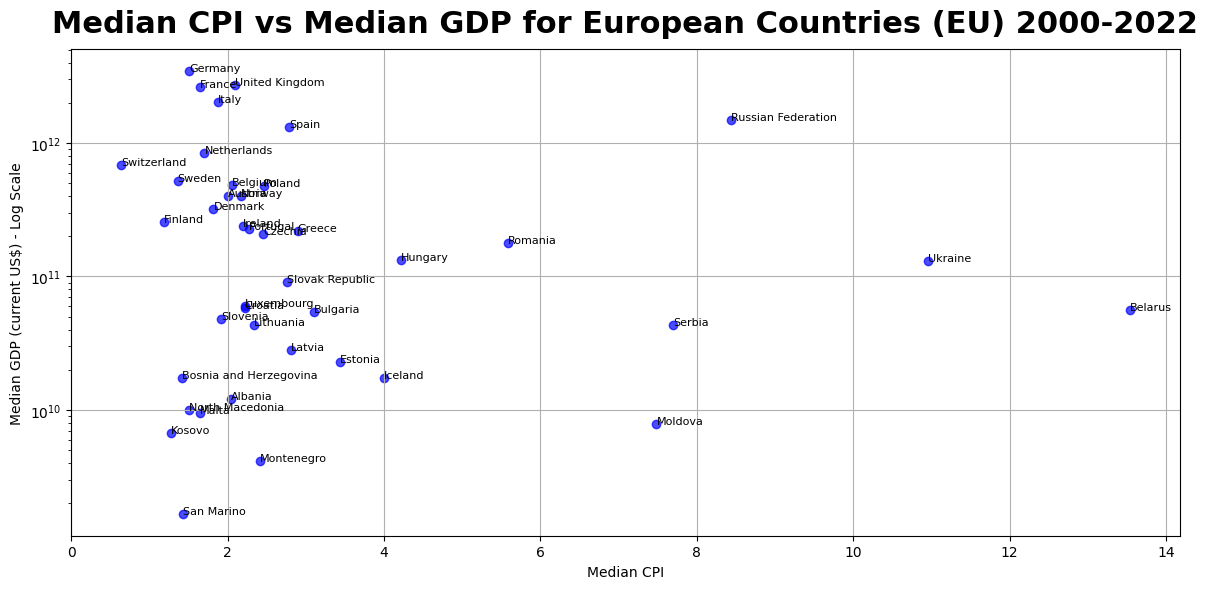

In [16]:
# Filter for European countries (EU)
df_cpi_eu = df_cpi_int[df_cpi_int['Continent'] == 'Europe']
df_gdp_eu = df_gdp_int[df_gdp_int['Continent'] == 'Europe']

# Merge the CPI and GDP data for EU and NA
df_merged_eu = pd.merge(df_cpi_eu, df_gdp_eu, on="Country Name", suffixes=('_cpi', '_gdp'))

# Calculate median CPI and GDP for each country in EU and NA across 2000-2022
df_merged_eu['median_cpi'] = df_merged_eu[cpi_columns].median(axis=1)
df_merged_eu['median_gdp'] = df_merged_eu[gdp_columns].median(axis=1)

# Scatter plot for European countries (EU)
plt.figure(figsize=(12, 6))
plt.scatter(df_merged_eu['median_cpi'], df_merged_eu['median_gdp'], alpha=0.7, color='blue')
plt.title('Median CPI vs Median GDP for European Countries (EU) 2000-2022', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Median CPI')
plt.ylabel('Median GDP (current US$)')
plt.grid(True)
if df_merged_eu['median_gdp'].max() / df_merged_eu['median_gdp'].min() > 1000:
    plt.yscale('log')
    plt.ylabel('Median GDP (current US$) - Log Scale')
for i, row in df_merged_eu.iterrows():
    plt.annotate(row['Country Name'], (row['median_cpi'], row['median_gdp']), fontsize=8)
plt.tight_layout()
plt.savefig(PLOT_PATH + f"median_cpi_and_gdp_scatterplot_in_Europe.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for processing economic data and creating a scatter plot to visualize the relationship between the Consumer Price Index (CPI) and GDP growth rate for European countries.
  <li>Reshapes the CPI and GDP data from wide to long format, preparing it for merging by country name and year. Calculates the GDP growth rate as a percentage change from the previous year for each country.
  <li>Merges the reshaped CPI data with the calculated GDP growth rates based on country and year. Removes any rows with missing values to clean the data for plotting.
  <li>Plots a scatter plot using Seaborn, mapping CPI to the x-axis and GDP growth rate to the y-axis, with different colors representing different countries. The plot does not include a legend to avoid cluttering.
  <li>Adds a regression line to the scatter plot to indicate trends, although the caption suggests that no clear pattern is discernible.
</ul>


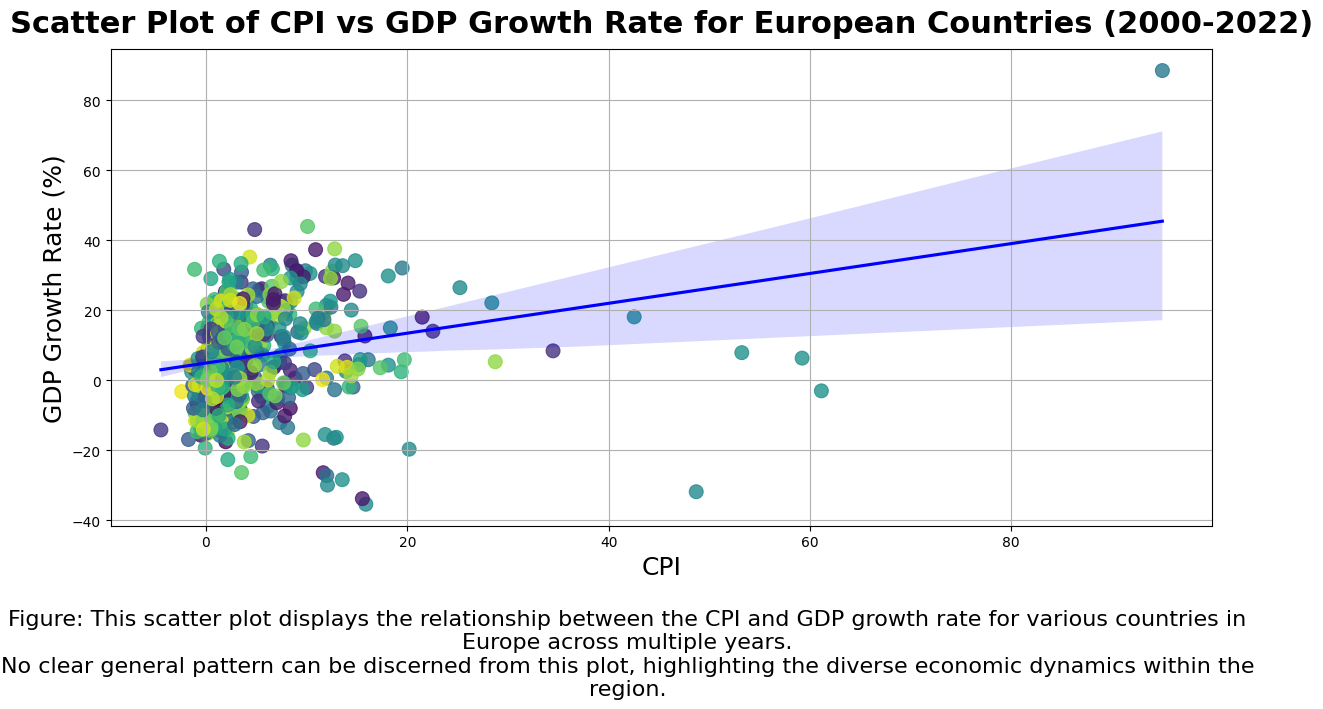

In [17]:
cpi_reshaped_countries = df_cpi_euro.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='CPI')

# Correcting the approach for merging and plotting
# Ensuring correct column names and merging the reshaped CPI and GDP growth data
gdp_growth_reshaped_countries = df_gdp_euro.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='GDP')
gdp_growth_reshaped_countries['GDP Growth Rate'] = gdp_growth_reshaped_countries.groupby('Country Name')['GDP'].pct_change() * 100  # Calculating GDP growth rate in percentage

# Merging the reshaped CPI and GDP growth dataframes for each country
merged_data_countries = pd.merge(cpi_reshaped_countries, gdp_growth_reshaped_countries[['Country Name', 'Year', 'GDP Growth Rate']], on=['Country Name', 'Year'])

# Removing NaN values
merged_data_countries = merged_data_countries.dropna()

# Creating the scatter plot for all countries across all years
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', hue='Country Name', palette='viridis', legend=False, s=100, alpha=0.8, edgecolor=None)
sns.regplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', scatter=False, color='blue')

plt.title('Scatter Plot of CPI vs GDP Growth Rate for European Countries (2000-2022)', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('CPI', fontsize=18)
plt.ylabel('GDP Growth Rate (%)', fontsize=18)
plt.grid(True)
caption = """Figure: This scatter plot displays the relationship between the CPI and GDP growth rate for various countries in Europe across multiple years.
No clear general pattern can be discerned from this plot, highlighting the diverse economic dynamics within the region."""
plt.tight_layout()
plt.figtext(0.5, -0.1, caption, ha='center', va='center', wrap=True, fontsize=16)
plt.savefig(PLOT_PATH + "cpi_and_gdp_growth_rate_scatterplot_in_Europe.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for data analysis and visualization, specifically for plotting the median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) growth rate for North American countries from 2000 to 2022. 
  <li>The code calculates the median CPI and median GDP growth rate for North American countries, using a dataset that categorizes data by continent. 
  <li>It performs a percentage change calculation on the GDP data to represent the growth rate and takes the median across North American countries for each year.
  <li>A line plot is created, with years on the x-axis and percentages on the y-axis, showing trends in median CPI and GDP growth, with markers for each year.
  <li>Vertical dashed lines and labels are added to highlight the years of the Global Financial Crisis (2008) and the Covid-19 Pandemic (2020).
</ul>

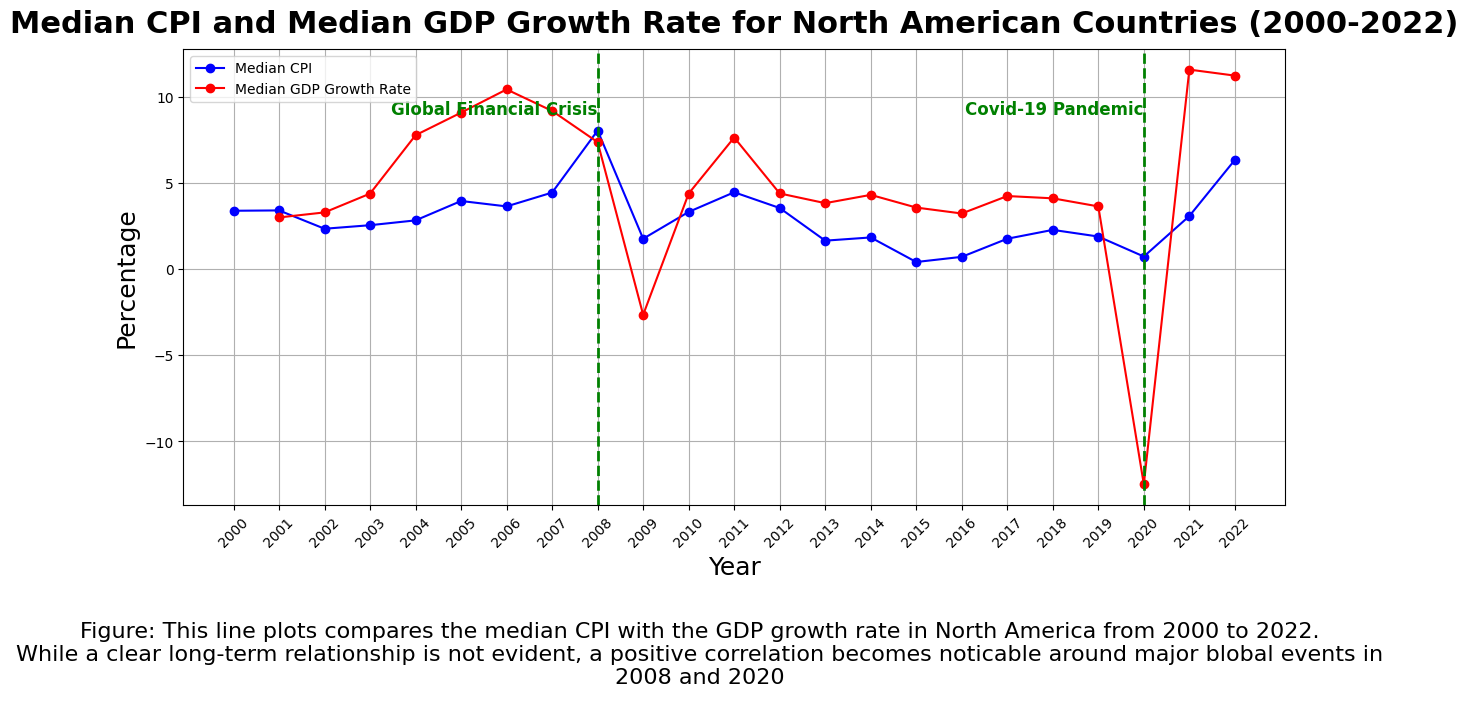

In [18]:
# North America
df_cpi_na = df_cpi_int[df_cpi_int['Continent'] == 'North America']
df_gdp_na = df_gdp_int[df_gdp_int['Continent'] == 'North America']

# Calculating GDP growth rate for North American countries
median_cpi_na = df_cpi_na[years].median()
gdp_growth_na = df_gdp_na[years].pct_change(axis = 1) * 100  # Convert to percentage
median_gdp_growth_na = gdp_growth_na.median()

# Plotting
plt.figure(figsize = (12, 6))
plt.plot(years, median_cpi_na, label = 'Median CPI', marker = 'o', color = 'blue')
plt.plot(years, median_gdp_growth_na, label = 'Median GDP Growth Rate', marker = 'o', color = 'red')

# Adding vertical lines for the years 2008 and 2020
plt.axvline(x='2008', color='green', linestyle='--', linewidth=2)
plt.axvline(x='2020', color='green', linestyle='--', linewidth=2)

# Label these global events
plt.text('2008', 9, 'Global Financial Crisis', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")
plt.text('2020', 9, 'Covid-19 Pandemic', horizontalalignment='right', color='green', fontsize=12, fontweight="bold")

plt.title('Median CPI and Median GDP Growth Rate for North American Countries (2000-2022)', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Year', fontsize=18)
plt.ylabel('Percentage', fontsize=18)
plt.xticks(rotation = 45)
plt.legend()
plt.grid(True)
caption = """Figure: This line plots compares the median CPI with the GDP growth rate in North America from 2000 to 2022.
While a clear long-term relationship is not evident, a positive correlation becomes noticable around major blobal events in 2008 and 2020"""
plt.figtext(0.5, -0.1, caption, ha='center', va='center', fontsize=16, wrap=True)
plt.tight_layout()
plt.savefig(PLOT_PATH + "median_cpi_and_gdp_growth_rate_in_North_America.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The below is creating a scatter plot visualizing the relationship between median Consumer Price Index (CPI) and median Gross Domestic Product (GDP) for North American countries, using data from the years 2000 to 2022.
  <li>Merges two datasets containing CPI and GDP data for North American countries, adding appropriate suffixes to distinguish the two.
  <li>Calculates the median CPI and median GDP for each country over the specified years.
  <li>Generates a scatter plot with median CPI on the x-axis and median GDP on the y-axis, applying a logarithmic scale to the GDP axis if there is a large range of values.
  <li>Annotates each data point with the corresponding country name for identification.
</ul>

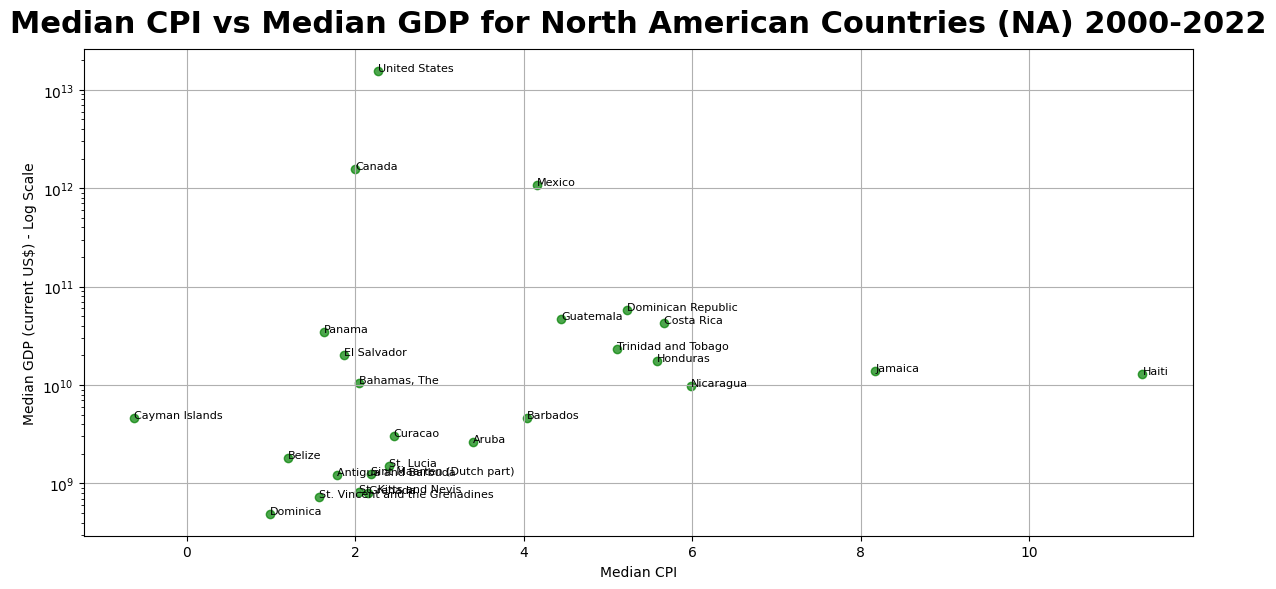

In [19]:
# Filter for North American countries (NA)
df_cpi_na = df_cpi_int[df_cpi_int['Continent'] == 'North America']
df_gdp_na = df_gdp_int[df_gdp_int['Continent'] == 'North America']

# Merge the CPI and GDP data for NA
df_merged_na = pd.merge(df_cpi_na, df_gdp_na, on="Country Name", suffixes=('_cpi', '_gdp'))

# Calculate median CPI and GDP for each country NA across 2000-2022
df_merged_na['median_cpi'] = df_merged_na[cpi_columns].median(axis=1)
df_merged_na['median_gdp'] = df_merged_na[gdp_columns].median(axis=1)

# Scatter plot for North American countries (NA)
plt.figure(figsize=(12, 6))
plt.scatter(df_merged_na['median_cpi'], df_merged_na['median_gdp'], alpha=0.7, color='green')
plt.title('Median CPI vs Median GDP for North American Countries (NA) 2000-2022', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('Median CPI')
plt.ylabel('Median GDP (current US$)')
plt.grid(True)
if df_merged_na['median_gdp'].max() / df_merged_na['median_gdp'].min() > 1000:
    plt.yscale('log')
    plt.ylabel('Median GDP (current US$) - Log Scale')
for i, row in df_merged_na.iterrows():
    plt.annotate(row['Country Name'], (row['median_cpi'], row['median_gdp']), fontsize=8)
plt.tight_layout()
plt.savefig(PLOT_PATH + f"median_cpi_and_gdp_scatterplot_in_North_America.png", dpi=300, bbox_inches='tight')
plt.show()

---

<h3 class="custom-heading"><b>Description</b></h3>
<ul class="custom-spacing">
  The code below is for processing economic data and creating a scatter plot to visualize the relationship between the Consumer Price Index (CPI) and GDP growth rate for North American countries.
  <li>Reshapes the CPI and GDP data from wide to long format, preparing it for merging by country name and year. Calculates the GDP growth rate as a percentage change from the previous year for each country.
  <li>Merges the reshaped CPI data with the calculated GDP growth rates based on country and year. Removes any rows with missing values to clean the data for plotting.
  <li>Plots a scatter plot using Seaborn, mapping CPI to the x-axis and GDP growth rate to the y-axis, with different colors representing different countries. The plot does not include a legend to avoid cluttering.
  <li>Adds a regression line to the scatter plot to indicate trends, although the caption suggests that no clear pattern is discernible.
</ul>


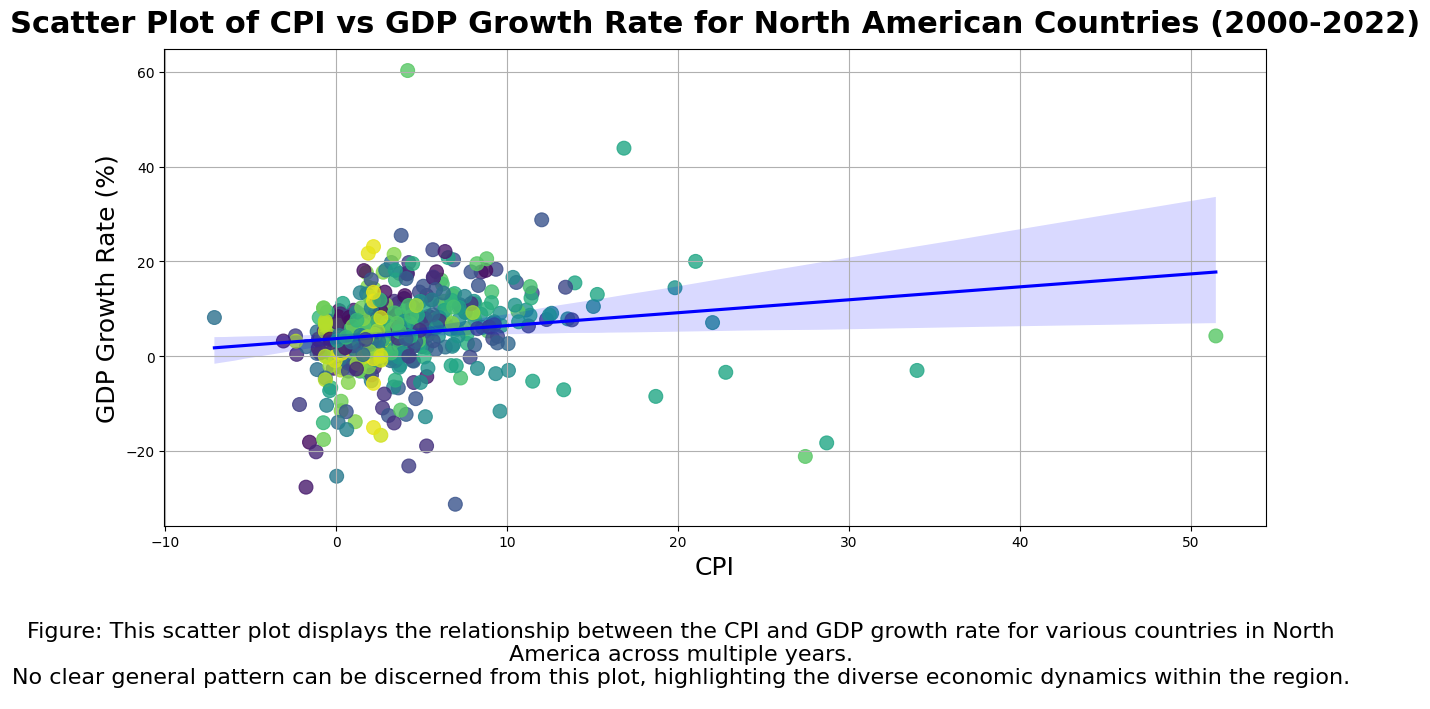

In [20]:
cpi_reshaped_countries = df_cpi_na.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='CPI')

# Correcting the approach for merging and plotting
# Ensuring correct column names and merging the reshaped CPI and GDP growth data
gdp_growth_reshaped_countries = df_gdp_na.melt(id_vars=['Country Name'], value_vars=years, var_name='Year', value_name='GDP')
gdp_growth_reshaped_countries['GDP Growth Rate'] = gdp_growth_reshaped_countries.groupby('Country Name')['GDP'].pct_change() * 100  # Calculating GDP growth rate in percentage

# Merging the reshaped CPI and GDP growth dataframes for each country
merged_data_countries = pd.merge(cpi_reshaped_countries, gdp_growth_reshaped_countries[['Country Name', 'Year', 'GDP Growth Rate']], on=['Country Name', 'Year'])

# Removing NaN values
merged_data_countries = merged_data_countries.dropna()

# Creating the scatter plot for all countries across all years
plt.figure(figsize=(12, 6))
sns.scatterplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', hue='Country Name', palette='viridis', legend=False, s=100, alpha=0.8, edgecolor=None)
sns.regplot(data=merged_data_countries, x='CPI', y='GDP Growth Rate', scatter=False, color='blue')

plt.title('Scatter Plot of CPI vs GDP Growth Rate for North American Countries (2000-2022)', fontsize=22, pad=12, fontweight="bold")
plt.xlabel('CPI', fontsize=18)
plt.ylabel('GDP Growth Rate (%)', fontsize=18)
plt.grid(True)
caption = """Figure: This scatter plot displays the relationship between the CPI and GDP growth rate for various countries in North America across multiple years.
No clear general pattern can be discerned from this plot, highlighting the diverse economic dynamics within the region."""
plt.figtext(0.5, -0.1, caption, ha='center', va='center', wrap=True, fontsize=16)
plt.tight_layout()
plt.savefig(PLOT_PATH + "cpi_and_gdp_growth_rate_scatterplot_in_North_America.png", dpi=300, bbox_inches='tight')
plt.show()

---

### **Phase Summary**
Our analysis of the relationship between the Consumer Price Index (CPI) and Gross Domestic Product (GDP) growth rates across various continents revealed intriguing patterns, especially during significant global events. Line plots showing median CPI and GDP growth rates annually indicated a generally positive correlation during crises, contrary to the expected inverse relationship.

**Key Observations:**
1. **Regional Variations**: In North American countries, despite a generally expected inverse relationship between CPI and GDP growth, during the global financial crisis and the COVID-19 pandemic, we noticed a positive correlation. This pattern was mirrored in European and Asian countries, albeit with different magnitudes and timings.

2. **Temporal Inconsistencies**: The positive correlation during crises contradicts the conventional wisdom of an inverse relationship, as highlighted by economic theories such as the Phillips Curve in the context of inflation and unemployment.

3. **Scatter Plot Analysis**: Merging CPI and GDP data for each country and year revealed that the scatter plots did not consistently show a clear negative correlation across continents.

4. **Impact of Global Events**: In the line plots, marked by vertical green dashed lines for the years 2008 and 2020, the global financial crisis and the COVID-19 pandemic respectively showed a positive correlation between CPI and GDP growth rates. During these years, both CPI and GDP growth rates increased or decreased simultaneously, which is atypical since a higher CPI, indicating inflation, is usually associated with lower GDP growth.

**Possible Reasons for Observations:**
1. **Economic Stimulus and Policies**: Governments often implement fiscal and monetary policies during crises to stimulate the economy, which might temporarily align the direction of CPI and GDP growth.

2. **Supply Chain Disruptions**: Crises can cause supply chain disruptions, leading to increased production costs and prices (reflected in CPI), while also reducing economic output (GDP growth).

3. **Consumer Behavior Changes**: During crises, consumer behavior may change, such as hoarding or changing spending patterns, influencing CPI and GDP growth in the same direction.

**Future Focus:**
We plan to narrow our focus to representative countries in each continent — China, Japan, and Korea for Asia; Germany, France, and Italy for Europe; and the USA, Canada, and Mexico for North America. This targeted approach will help us examine if a more distinct and convincing correlation exists within these countries.
